# <font color='brown'>Setup </font>

In [1]:
%%time
import os
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm
from matplotlib import pyplot as plt
import seaborn as sns

Wall time: 4.93 s


In [2]:
def fix_current_folder():
    folder = os.getcwd().split("\\")[-1]
    if folder == "Classification_datascience":
        os.chdir("webscrapping")
        print("Path updated!")

# <font color='brown'>Dataframe </font>

In [4]:
match = 39978
series = 18686

In [6]:
fix_current_folder()
from typing import List
from match_analysis import RoundReplay, generate_prediction_model, generate_round_replay_example

Path updated!
17


In [7]:
%%time
rr = generate_round_replay_example(match, series)

match → 39978 series → 18686
File downloaded at matches/json/39978.json


KeyError: 'matchDetails'

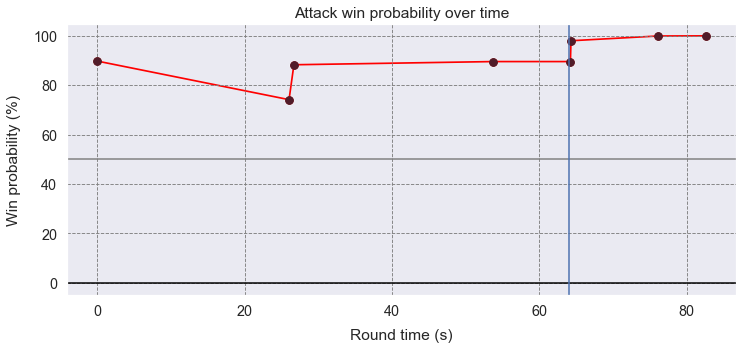

In [14]:
rr.plot_round(5, side="atk")

In [8]:
round_data
#for dot in zip(round_data["Round time"], round_data["Win_probability"]):
    #print(dot)

,Round time,Win_probability,Difference (%),Final Winner,Round,Integer time
327500,0.00,37.56,0.00,def,15,0
327501,17.58,60.05,22.49,def,15,18
327502,20.22,39.70,-20.35,def,15,20
327503,23.13,21.13,-18.57,def,15,23
327504,24.23,43.97,22.84,def,15,24
327505,24.59,17.42,-26.55,def,15,25
327506,30.25,41.15,23.73,def,15,30
327507,37.93,79.65,38.50,def,15,38
327508,38.45,38.31,-41.34,def,15,38
327509,39.60,0.14,-38.17,def,15,40


In [10]:
rr.get_round_probability(15, side="atk")

,Round time,Win_probability,Difference (%),Final Winner,Round
327500,0,37.56,0.00,def,15
327501,17,60.05,22.49,def,15
327502,20,39.70,-20.35,def,15
327503,23,21.13,-18.57,def,15
327504,24,43.97,22.84,def,15
327505,24,17.42,-26.55,def,15
327506,30,41.15,23.73,def,15
327507,37,79.65,38.50,def,15
327508,38,38.31,-41.34,def,15
327509,39,0.14,-38.17,def,15


In [14]:
rr.get_clutchy_rounds("atk")

{6: 10.96,
 4: 43.83,
 23: 44.56,
 8: 45.79,
 22: 45.79,
 13: 45.98,
 19: 46.16,
 17: 46.72,
 24: 49.58,
 3: 66.0,
 9: 66.01,
 5: 74.13,
 7: 79.85,
 20: 85.71,
 14: 96.6}

In [21]:
rr.get_round_dataframe(7)

,RoundID,RoundNumber,RoundTime,ATK_wealth,DEF_wealth,ATK_alive,DEF_alive,DEF_has_OP,Def_has_Odin,RegularTime,...,DEF_duelists,DEF_sentinels,DEF_controllers,ATK_Shields,DEF_Shields,MapName,MatchID,SeriesID,bestOF,FinalWinner
327429,640246,7,0,14500,5200,5,5,0,0,0,...,2,1,1,250,125,Haven,39944,18674,3,1
327430,640246,7,37110,14500,5200,5,4,0,0,37,...,1,1,1,250,75,Haven,39944,18674,3,1
327431,640246,7,58165,14500,3600,5,3,0,0,58,...,1,0,1,250,50,Haven,39944,18674,3,1
327432,640246,7,62380,14500,2600,5,2,0,0,62,...,1,0,0,250,50,Haven,39944,18674,3,1
327433,640246,7,66217,11600,2600,4,2,0,0,66,...,1,0,0,200,50,Haven,39944,18674,3,1
327434,640246,7,71627,11600,2600,4,2,0,0,72,...,1,0,0,200,50,Haven,39944,18674,3,1
327435,640246,7,80159,11600,1000,4,1,0,0,0,...,0,0,0,200,25,Haven,39944,18674,3,1
327436,640246,7,86549,11600,0,4,0,0,0,0,...,0,0,0,200,0,Haven,39944,18674,3,1


In [35]:
r_number = pd.Series(rr.get_round_table().keys())
r_atk = pd.Series(rr.get_atk_scores())
r_def = pd.Series(rr.get_def_scores())
r_winner = pd.Series([rr.get_match_winner()] * len(r_number))
r_ids = pd.Series([rr.match_id] * len(r_number))

frame = {'MatchID': r_ids, 'RoundNumber': r_number, 'AtkScore': r_atk, 'DefScore': r_def, 'FinalWinner': r_winner}

match_frame = pd.DataFrame(frame)

AttributeError: 'RoundReplay' object has no attribute 'get_atk_scores'

In [ ]:
match_frame

https://runitback.gg/series/12745?match=25645&round=19&tab=replay

# Match

In [ ]:
match = 26508
path2 = 'D:\\Documents\\GitHub\\Classification_datascience\\webscrapping\\matches\\rounds\\combined_csv.csv'
data = pd.read_csv('{}'.format(path2))

In [ ]:
class MatchReplay:
    def __init__(self, match_id: int, input_df: pd.DataFrame):
        self.df: pd.DataFrame = input_df
        self.match_id: int = match_id
        self.query: pd.DataFrame = input_df.query('MatchID == {}'.format(match_id))

    def get_round_table(self) -> dict:
        g = self.query[["RoundNumber", "RoundID"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.RoundID))

    def get_atk_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        atk_scores = []

        for i in dfm[:12]:
            if i == 1:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])
        for j in dfm[12:24]:
            if j == 0:
                score_dict['atk'] += 1
            atk_scores.append(score_dict['atk'])

        return atk_scores

    def get_round_winners(self) -> dict:
        g = self.query[["RoundNumber", "FinalWinner"]]
        g.drop_duplicates()
        return dict(zip(g.RoundNumber, g.FinalWinner))

    def get_def_scores(self) -> List[int]:
        dfm = list(self.get_round_winners().values())
        score_dict = {'atk': 0, 'def': 0}
        def_scores = []

        for i in dfm[:12]:
            if i == 0:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])
        for j in dfm[12:24]:
            if j == 1:
                score_dict['def'] += 1
            def_scores.append(score_dict['def'])

        return def_scores

    def get_match_winner(self) -> int:
        atks = self.get_atk_scores()
        defs = self.get_def_scores()

        winner = 0
        if atks[-1] == 12 and defs[-1] == 12:
            winner = 2
        elif atks[-1] == 13:
            winner = 1
        elif defs[-1] == 13:
            winner = 0
        return winner

    def generate_match_dataframe(self) -> pd.DataFrame:
        r_number = pd.Series(self.get_round_table().keys())
        r_atk = pd.Series(self.get_atk_scores())
        r_def = pd.Series(self.get_def_scores())
        r_winner = pd.Series([self.get_match_winner()] * len(r_number))
        r_ids = pd.Series([self.match_id] * len(r_number))

        frame = {'MatchID': r_ids, 'RoundNumber': r_number, 'AtkScore': r_atk, 'DefScore': r_def,
                 'FinalWinner': r_winner}

        d_frame = pd.DataFrame(frame)
        d_frame.dropna()

        return d_frame

    def get_all_matches(self) -> set:
        return set(self.df.MatchID)
    
    def get_atk_bank(self):
        return [
            max(self.query.query('RoundNumber == {}'.format(r)).ATK_bank)
            for r in self.get_round_table().keys()
        ]

    def get_big_dataframe(self):
        df_list = []
        match_indexes = list(self.get_all_matches())

        for i in match_indexes:
            self.match_id = i
            self.query: pd.DataFrame = self.df.query('MatchID == {}'.format(i))
            df_list.append(self.generate_match_dataframe())

        merged = pd.concat(df_list)
        merged.dropna(inplace=True)
        merged["AtkScore"] = merged["AtkScore"].astype(int)
        merged["DefScore"] = merged["DefScore"].astype(int)

        return merged

    def export_big_dataframe(self):
        big_df = self.get_big_dataframe()
        big_df.to_csv(r'matches\rounds\matches_csv.csv', index=False)
        
mr = MatchReplay(match, data)

In [ ]:
%%time
qq = mr.get_big_dataframe()
qq

In [ ]:
mr.get_atk_bank()

In [ ]:
mr.generate_match_dataframe()